Author: Zidong Chen<br />
Date: 2024/06/22

In [12]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import GP_CommonCalculation as GP
from non_positive_definite_fixer import remove_similar_data
import importlib
importlib.reload(GP)
EPS = 1e-10
PI = 3.1415

### 这是一个解决梯度爆炸的两种方案：
#### 方案1：梯度裁剪,即在梯度过大的时候对梯度缩小。[相关技术博客](https://developer.aliyun.com/article/1462215#:~:text=%E6%A2%AF%E5%BA%A6%E8%A3%81%E5%89%AA%EF%BC%88Gradient%20Clipping%EF%BC%89%E6%98%AF,%E7%AC%A6%E5%8F%B7%E4%B9%98%E4%BB%A5%E8%AF%A5%E9%98%88%E5%80%BC%E3%80%82)
implement:在反向传播，计算梯度后加入下列代码：\
torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm)

#### 方案2：参数重置，即在参数超过一个范围的时候将其重置

implement
在设置完模型参数预设值以后得到模型的参数预设值,详见注释1


用一个function实现重置，详见注释2


在更新参数以后判断参数是否爆炸，如果爆炸就重置，别忘记预设max_norm的值,详见注释3


In [13]:
#组装模型

import torch.optim as optim
from kernel import ARDKernel  # 假设 ARDKernel 在 kernel 模块中定义
JITTER = 1e-5
class vsgp(nn.Module):
    def __init__(self, X, Y, num_inducing, normal_y_mode=0):
        super(vsgp, self).__init__()

        self.data = GP.data_normalization(X, Y, normal_y_mode)
        self.X, self.Y = self.data.normalize(X, Y)
        self.X, self.Y = remove_similar_data(self.X, self.Y)

        # GP hyperparameters
        self.log_beta = nn.Parameter(torch.ones(1) * -4)  # Initial noise level
        self.log_length_scale = nn.Parameter(torch.zeros(1))  # Initial length scale
        self.log_scale = nn.Parameter(torch.zeros(1))  # Initial scale
        
        # 注释1:Save initial values for resetting
        self.initial_log_length_scale = self.log_length_scale.clone().detach()
        self.initial_log_scale = self.log_scale.clone().detach()

        # Inducing points
        subset_indices = torch.randperm(self.X.size(0))[:num_inducing]
        self.xm = nn.Parameter(self.X[subset_indices])  # Inducing points
    def kernel(self, X1, X2):
        # the common RBF kernel
        X1 = X1 / self.log_length_scale.exp()
        X2 = X2 / self.log_length_scale.exp()
        # X1_norm2 = X1 * X1
        # X2_norm2 = X2 * X2
        X1_norm2 = torch.sum(X1 * X1, dim=1).view(-1, 1)
        X2_norm2 = torch.sum(X2 * X2, dim=1).view(-1, 1)

        K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0), X2.size(0))  #this is the effective Euclidean distance matrix between X1 and X2.
        K = self.log_scale.exp() * torch.exp(-0.5 * K)
        return K

    def negative_lower_bound(self):
        """Negative lower bound as the loss function to minimize."""
        n = self.X.size(0)
        K_mm = self.kernel(self.xm, self.xm) + JITTER * torch.eye(self.xm.size(0))
        L = torch.linalg.cholesky(K_mm)
        K_mn = self.kernel(self.xm, self.X)
        K_nn = self.kernel(self.X, self.X)
        A = torch.linalg.solve_triangular(L, K_mn, upper=False)
        A = A * torch.sqrt(self.log_beta.exp())
        AAT = A @ A.t()
        B = torch.eye(self.xm.size(0)) + AAT + JITTER * torch.eye(self.xm.size(0))
        LB = torch.linalg.cholesky(B)

        c = torch.linalg.solve_triangular(LB, A @ self.Y, upper=False)
        c = c * torch.sqrt(self.log_beta.exp())
        nll = (n / 2 * torch.log(2 * torch.tensor(PI)) +
               torch.sum(torch.log(torch.diagonal(LB))) +
               n / 2 * torch.log(1 / self.log_beta.exp()) +
               self.log_beta.exp() / 2 * torch.sum(self.Y * self.Y) -
               0.5 * torch.sum(c.squeeze() * c.squeeze()) +
               self.log_beta.exp() / 2 * torch.sum(torch.diagonal(K_nn)) -
               0.5 * torch.trace(AAT))
        return nll

    def optimal_inducing_point(self):
        """Compute optimal inducing points mean and covariance."""
        K_mm = self.kernel(self.xm, self.xm) + JITTER * torch.eye(self.xm.size(0))
        L = torch.linalg.cholesky(K_mm)
        L_inv = torch.inverse(L)
        K_mm_inv = L_inv.t() @ L_inv

        K_mn = self.kernel(self.xm, self.X)
        K_nm = K_mn.t()
        sigma = torch.inverse(K_mm + self.log_beta.exp() * K_mn @ K_nm)

        mean_m = self.log_beta.exp() * (K_mm @ sigma @ K_mn) @ self.Y
        A_m = K_mm @ sigma @ K_mm
        return mean_m, A_m, K_mm_inv

    def forward(self, Xte):
        """Compute mean and variance for posterior distribution."""
        Xte = self.data.normalize(Xte)
        K_tt = self.kernel(Xte, Xte)
        K_tm = self.kernel(Xte, self.xm)
        K_mt = K_tm.t()
        mean_m, A_m, K_mm_inv = self.optimal_inducing_point()
        mean = (K_tm @ K_mm_inv) @ mean_m
        var = (K_tt - K_tm @ K_mm_inv @ K_mt +
               K_tm @ K_mm_inv @ A_m @ K_mm_inv @ K_mt)
        var_diag = var.diag().view(-1, 1)
        mean, var_diag = self.data.denormalize_result(mean, var_diag)
        return mean, var_diag
    
    def reset_parameters(self):
        # 注释2:Reset parameters to their initial state around initial values
        self.log_length_scale.data.uniform_(self.initial_log_length_scale - 0.1, self.initial_log_length_scale + 0.1)
        self.log_scale.data.uniform_(self.initial_log_scale - 0.1, self.initial_log_scale + 0.1)
    
    def train_adam_with_reset(self, niteration=100, lr=0.01, max_norm=5):
        """Train model using Adam optimizer."""
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        for iteration in range(niteration):
            try:
                optimizer.zero_grad()
                loss = self.negative_lower_bound()
                
                loss.backward()  # Compute gradients
                
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm)  # Clip gradients to avoid explosion
                
                optimizer.step()  # Update parameters
                
                # 注释3:Check parameter norms and reset if necessary
                with torch.no_grad():
                    for param_name, param in [ ('log_length_scale', self.log_length_scale), ('log_scale', self.log_scale)]:
                        param_norm = torch.norm(param)
                        #print(f"{param_name} norm before reset check: {param_norm}")  # Debugging line
                        if param_norm > max_norm:
                            print(f"Parameter {param_name} norm {param_norm} exceeds max_norm, resetting parameters.")
                            self.reset_parameters()
                            break
                if iteration % 10 == 0:
                    print(f'Loss: {loss.item()}')
            
            except Exception as e:#我们可以检查出现非正定问题不是由参数爆炸引起的
                print(f'Error during optimization at iteration {iteration}: {e}')
                # Log specific parameters during the error
                print(f'Iteration {iteration} error state:')
                print(f'log_beta: {self.log_beta.item()}')
                print(f'log_length_scale: {self.log_length_scale}')
                print(f'log_scale: {self.log_scale}')
                raise e

xtr.size: torch.Size([200, 1]) ytr.size: torch.Size([200, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


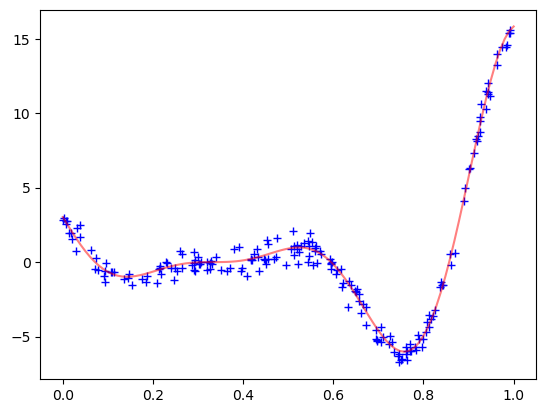

In [14]:
torch.manual_seed(4)
xtr = torch.rand(200, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(200, 1) * 0.5

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

Loss: 586.5841674804688
Loss: 489.55340576171875
Loss: 397.9791564941406
Loss: 319.07666015625
Loss: 218.57943725585938


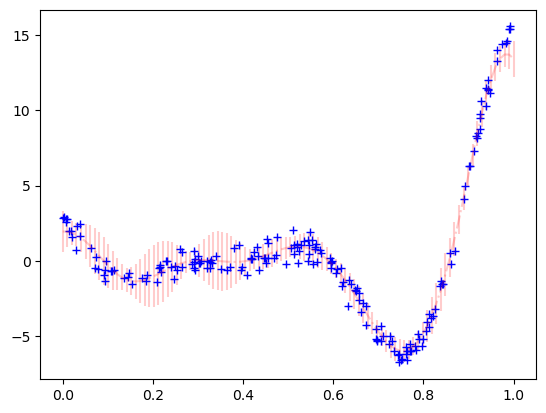

In [15]:
model=vsgp(xtr,ytr,10)
model.train_adam_with_reset(50,0.1)
with torch.no_grad():
    ypred, yvar = model.forward(xte)
    
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()